# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [1]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=59f84e2ac7e38cd571b3456733f01768331b68c5de9d7ddfb36602ee9f4ad87b
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [3]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date,
                 auto_adjust=False).stack()  # auto_adjust=False is crucial here

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['GEV', 'SW', 'SOLV', 'VLTO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')


In [4]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.317404   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.568563   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.385227   52.790001   54.189999   51.880001   53.099998   
           ABT      32.972778   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      87.981140   89.519997   90.849998   89.500000   90.379997   
           YUM     120.448677  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.037552  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     174.190506  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
           ACGL      1888800.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[984472 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [5]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.317404   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.568563   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.385227   52.790001   54.189999   51.880001   53.099998   
           ABT      32.972778   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      87.981140   89.519997   90.849998   89.500000   90.379997   
           YUM     120.448677  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.037552  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     174.190506  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001245        NaN       NaN   
           AAPL    293461600.0         -0.006066        NaN       NaN   
           ABBV     12842800.0         -0.062689        NaN       NaN   
           ABT      12287500.0         -0.011366        NaN       NaN   
           ACGL      1888800.0         -0.000516        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000167  26.146727  4.477311   
           YUM       1500600.0         -0.000317  36.057165  4.797300   
           ZBH       3610500.0         -0.000144  31.893247  4.741455   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000004  42.623487  5.148392   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.539320  
           AAPL         NaN       NaN       NaN       NaN    7209.929943  
           ABBV         NaN       NaN       NaN       NaN     454.445396  
           ABT          NaN       NaN       NaN       NaN     405.153014  
           ACGL         NaN       NaN       NaN       NaN      43.853730  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.559227  4.641143  0.033800 -2.159189     116.346260  
           YUM     4.827262  4.857224  0.142547 -1.363696     180.745285  
           ZBH     4.781120  4.820785 -0.381708 -0.881067     400.901081  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.207203  5.266014  0.651515 -1.188279     254.875548  

[984472 rows x 14 columns]

<Axes: xlabel='date'>

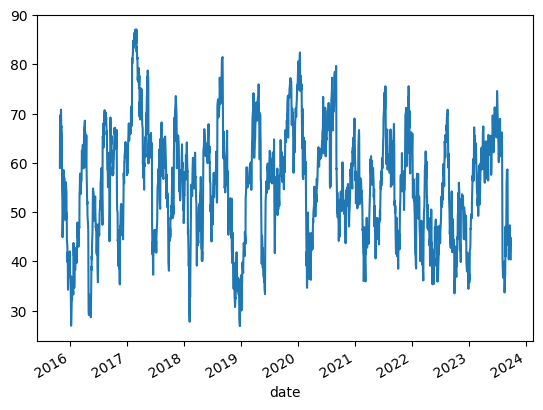

In [6]:
df.xs('AAPL', level=1)['rsi'].plot()

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [7]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.275130   38.817242         -0.002300  73.421509   
           AAPL      4010.505064   26.764181         -0.003555  55.537300   
           ABBV       328.741166   39.337776         -0.067902  49.376840   
           ABT        208.460525   37.714897         -0.013319  56.962574   
           ACGL        28.174423   22.970539         -0.001121  35.682522   
...                          ...         ...               ...        ...   
2023-09-30 PLTR       651.345225   13.960000          0.000214  41.544692   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        195.997267  107.492867          0.000035  55.245480   
           GEHC       212.040142   66.056786          0.000184  40.922327   
           KVUE       652.144702   19.449688         -0.001094  35.706328   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.540853  3.613291  3.685729 -1.033887  0.567157  
           AAPL    3.278450  3.321756  3.365063 -0.967900 -0.142790  
           ABBV    3.700855  3.749074  3.797293 -0.526809  0.145676  
           ABT     3.641225  3.663070  3.684915 -1.064842  0.335558  
           ACGL    3.177974  3.195190  3.212406 -1.155694 -0.550166  
...                     ...       ...       ...       ...       ...  
2023-09-30 PLTR    2.701939  2.779743  2.857548 -0.426167 -0.433581  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.648751  4.688923  4.729095 -0.436215  0.366876  
           GEHC    4.154342  4.211877  4.269412 -0.893478 -1.116463  
           KVUE    2.987464  3.062313  3.137163 -0.899746 -1.435620  

[46483 rows x 9 columns]

In [8]:
# For each month, keep only the top 150 stocks by dollar volume
data = (data.reset_index()
        .groupby('date')
        .apply(lambda x: x.nlargest(150, 'dollar_volume'))
        .reset_index(drop=True)
        .set_index(['date', 'ticker']))

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 GE        4378.304828  126.567650         -0.007257  59.411590   
           AAPL      4010.505064   26.764181         -0.003555  55.537300   
           META      2890.566167  103.843323          0.000111  55.404363   
           AMZN      2869.513198   33.240002          0.000202  65.506651   
           NFLX      1858.387317  123.330002          0.000261  62.768814   
...                          ...         ...               ...        ...   
2023-09-30 NXPI       317.161279  191.722656         -0.000128  43.876069   
           ICE        316.779375  105.543922         -0.000199  32.275109   
           MCK        316.643185  440.362152          0.000039  63.142345   
           WBA        314.211671   19.080667         -0.004203  25.028833   
           WDAY       314.184627  229.240005          0.000141  43.976804   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 GE      4.829783  4.855679  4.881575  1.406925  1.341278  
           AAPL    3.278450  3.321756  3.365063 -0.967900 -0.142790  
           META    4.634240  4.668615  4.702989 -1.165352  0.202517  
           AMZN    3.478346  3.522721  3.567095 -1.126602  0.336611  
           NFLX    4.649410  4.761208  4.873006 -1.108792  0.335120  
...                     ...       ...       ...       ...       ...  
2023-09-30 NXPI    5.250320  5.291408  5.332496  0.397588 -0.933716  
           ICE     4.684617  4.733880  4.783144  0.015665 -1.092962  
           MCK     5.996218  6.047643  6.099067  1.117551  1.524894  
           WBA     2.947148  3.058650  3.170151 -1.813421 -1.474187  
           WDAY    5.437299  5.495242  5.553185 -0.127668 -0.306858  

[14250 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [9]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAPL     26.124672         -0.002681  49.891102  3.291006   
           AMZN     39.491001          0.000101  44.759366  3.701219   
           META    130.491531         -0.000007  56.188434  4.845203   
           MSFT     53.831604         -0.004738  61.097613  3.932135   
           NFLX    124.870003          0.000102  70.794120  4.533780   
...                       ...               ...        ...       ...   
2023-09-30 DAL      36.188698          0.000053  28.236878  3.609392   
           BDX     255.542130         -0.000222  39.860839  5.533204   
           NXPI    191.722656         -0.000128  43.876069  5.250320   
           MCK     440.362152          0.000039  63.142345  5.996218   
           WDAY    229.240005          0.000141  43.976804  5.437299   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAPL    3.319883  3.348759 -1.038688 -0.195978  
           AMZN    3.742006  3.782792 -1.145117 -0.174728  
           META    4.869480  4.893757 -1.371781  0.028840  
           MSFT    3.979545  4.026956 -1.083480 -0.102606  
           NFLX    4.737018  4.940256 -1.309784  0.601504  
...                     ...       ...       ...       ...  
2023-09-30 DAL     3.704181  3.798971 -0.871571 -1.268630  
           BDX     5.575007  5.616810 -0.096187 -1.065509  
           NXPI    5.291408  5.332496  0.397588 -0.933716  
           MCK     6.047643  6.099067  1.117551  1.524894  
           WDAY    5.495242  5.553185 -0.127668 -0.306858  

[11408 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [11]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-10-31 AMZN     79.900497          0.000560  38.011002  4.360318   
           AAPL     52.021114         -0.000509  50.232893  3.935196   
           NFLX    301.779999          0.001403  40.694570  5.649481   
           META    151.212372          0.000951  44.054750  4.970340   
           MSFT    100.039993         -0.000736  46.806776  4.576027   
...                       ...               ...        ...       ...   
2023-09-30 DAL      36.188698          0.000053  28.236878  3.609392   
           BDX     255.542130         -0.000222  39.860839  5.533204   
           NXPI    191.722656         -0.000128  43.876069  5.250320   
           MCK     440.362152          0.000039  63.142345  5.996218   
           WDAY    229.240005          0.000141  43.976804  5.437299   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-10-31 AMZN    4.482820  4.605322  0.852380 -1.894748  -0.202192   
           AAPL    3.973559  4.011922 -0.265596 -0.447839  -0.030478   
           NFLX    5.796371  5.943261  1.646400 -1.684431  -0.193382   
           META    5.033360  5.096381  0.082839 -0.926632  -0.077040   
           MSFT    4.628814  4.681601 -0.007395 -0.840702  -0.066102   
...                     ...       ...       ...       ...        ...   
2023-09-30 DAL     3.704181  3.798971 -0.871571 -1.268630  -0.205145   
           BDX     5.575007  5.616810 -0.096187 -1.065509  -0.063040   
           NXPI    5.291408  5.332496  0.397588 -0.933716  -0.047412   
           MCK     6.047643  6.099067  1.117551  1.524894   0.074481   
           WDAY    5.495242  5.553185 -0.127668 -0.306858  -0.062413   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-10-31 AMZN    -0.108956  -0.034850   0.003364   0.010789    0.031198  
           AAPL    -0.019453   0.048955   0.049216   0.031518    0.023037  
           NFLX    -0.094037  -0.036555  -0.005780   0.012316    0.036431  
           META    -0.070609  -0.041885  -0.020617  -0.022849   -0.014132  
           MSFT    -0.024880   0.003573   0.023785   0.014540    0.022577  
...                      ...        ...        ...        ...         ...  
2023-09-30 DAL     -0.119615   0.024066   0.024856  -0.017088   -0.006174  
           BDX      0.030496   0.050748   0.021314   0.006654    0.015766  
           NXPI    -0.062529  -0.014397   0.017595   0.035025    0.007121  
           MCK      0.065459   0.068477   0.028874   0.021800    0.025813  
           WDAY    -0.016777   0.004919   0.017531   0.035597    0.028010  

[7044 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [12]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-10-31 AAPL   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.030478
           ABBV   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.168082
           ABT    -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.056387
           ACN    -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.065449
           ADBE   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.089609
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VZ     -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.056889
           WDAY   -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.062413
           WFC    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.015500
           WMT    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.000676
           XOM    -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.046947

[7044 rows x 6 columns]

In [13]:
factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2018-10-31,-0.0768,-0.0445,0.0340,0.0095,0.0358,-0.030478
2018-11-30,0.0169,-0.0077,0.0028,-0.0055,0.0039,-0.161253
2018-12-31,-0.0957,-0.0288,-0.0188,-0.0003,0.0021,-0.116698
2019-01-31,0.0840,0.0301,-0.0045,-0.0078,-0.0152,0.055154
2019-02-28,0.0340,0.0175,-0.0271,0.0012,-0.0160,0.044777


In [14]:
factor_data.xs('MSFT', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2018-10-31,-0.0768,-0.0445,0.0340,0.0095,0.0358,-0.066102
2018-11-30,0.0169,-0.0077,0.0028,-0.0055,0.0039,0.042684
2018-12-31,-0.0957,-0.0288,-0.0188,-0.0003,0.0021,-0.084047
2019-01-31,0.0840,0.0301,-0.0045,-0.0078,-0.0152,0.028158
2019-02-28,0.0340,0.0175,-0.0271,0.0012,-0.0160,0.077357


* Filter out stocks with less than 10 months of data.

In [15]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-10-31 AAPL   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.030478
           ABBV   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.168082
           ABT    -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.056387
           ACN    -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.065449
           ADBE   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.089609
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VZ     -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.056889
           WDAY   -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.062413
           WFC    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.015500
           WMT    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.000676
           XOM    -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.046947

[6992 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [16]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VZ      0.328192 -0.159646  0.257549  0.321767  0.107620
           WDAY    1.057170 -0.994627 -0.651196 -0.850404 -0.224353
           WFC     1.112945  0.306861  2.044025 -0.451833 -1.511412
           WMT     0.703218 -0.309964 -0.427675 -0.156621  0.526861
           XOM     0.974446 -1.078106  1.740532 -0.633260 -0.367966

[6992 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [17]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6613 entries, (Timestamp('2018-10-31 00:00:00'), 'AMZN') to (Timestamp('2023-09-30 00:00:00'), 'WDAY')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  6613 non-null   float64
 1   rsi               6613 non-null   float64
 2   bb_low            6613 non-null   float64
 3   bb_mid            6613 non-null   float64
 4   bb_high           6613 non-null   float64
 5   atr               6613 non-null   float64
 6   macd              6613 non-null   float64
 7   return_1m         6613 non-null   float64
 8   return_2m         6613 non-null   float64
 9   return_3m         6613 non-null   float64
 10  return_6m         6613 non-null   float64
 11  return_9m         6613 non-null   float64
 12  return_12m        6613 non-null   float64
 13  Mkt-RF            6613 non-null   float64
 14  SMB               6613 non-null   float64
 15  HML       

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

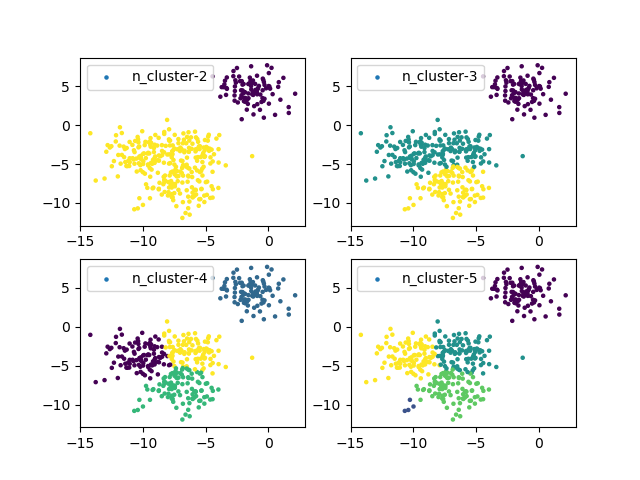

In [26]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_ # init=initial_centroids
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-10-31 AMZN            0.000560  38.011002  4.360318  4.482820  4.605322   
           AAPL           -0.000509  50.232893  3.935196  3.973559  4.011922   
           NFLX            0.001403  40.694570  5.649481  5.796371  5.943261   
           META            0.000951  44.054750  4.970340  5.033360  5.096381   
           MSFT           -0.000736  46.806776  4.576027  4.628814  4.681601   
...                             ...        ...       ...       ...       ...   
2023-09-30 SHW             0.000046  37.374296  5.523133  5.574313  5.625494   
           VRTX            0.000037  52.406728  5.838959  5.859127  5.879295   
           DAL             0.000053  28.236878  3.609392  3.704181  3.798971   
           NXPI           -0.000128  43.876069  5.250320  5.291408  5.332496   
           WDAY            0.000141  43.976804  5.437299  5.495242  5.553185   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-10-31 AMZN    0.852380 -1.894748  -0.202192  -0.108956  -0.034850   
           AAPL   -0.265596 -0.447839  -0.030478  -0.019453   0.048955   
           NFLX    1.646400 -1.684431  -0.193382  -0.094037  -0.036555   
           META    0.082839 -0.926632  -0.077040  -0.070609  -0.041885   
           MSFT   -0.007395 -0.840702  -0.066102  -0.024880   0.003573   
...                     ...       ...        ...        ...        ...   
2023-09-30 SHW     0.143619 -1.307017  -0.065693  -0.040732   0.024074   
           VRTX    0.029799  0.027907   0.009617  -0.000923  -0.000208   
           DAL    -0.871571 -1.268630  -0.205145  -0.119615   0.024066   
           NXPI    0.397588 -0.933716  -0.047412  -0.062529  -0.014397   
           WDAY   -0.127668 -0.306858  -0.062413  -0.016777   0.004919   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-10-31 AMZN     0.003364   0.010789    0.031198  1.247525 -0.538557   
           AAPL     0.049216   0.031518    0.023037  1.334388 -0.391352   
           NFLX    -0.005780   0.012316    0.036431  1.150240  0.211217   
           META    -0.020617  -0.022849   -0.014132  1.036079 -0.609575   
           MSFT     0.023785   0.014540    0.022577  0.897541 -0.415410   
...                      ...        ...         ...       ...       ...   
2023-09-30 SHW      0.004383   0.006757   -0.005403  1.085424 -0.610431   
           VRTX     0.032495   0.011819    0.018646  0.089782  0.351948   
           DAL      0.024856  -0.017088   -0.006174  1.095318  1.017168   
           NXPI     0.017595   0.035025    0.007121  1.271097  0.231634   
           WDAY     0.017531   0.035597    0.028010  1.092694 -1.170656   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-10-31 AMZN   -0.476700 -0.379313  0.021713        1  
           AAPL   -0.691821  0.447805  0.775388        0  
           NFLX   -0.238617 -0.780169 -0.917919        1  
           META   -0.308887  0.865899 -0.255266        1  
           MSFT   -0.382410  0.147251  0.073683        0  
...                     ...       ...       ...      ...  
2023-09-30 SHW    -0.312455  0.406985  0.296502        0  
           VRTX    0.450582  0.513224  0.136956        1  
           DAL     1.525403  0.047885 -0.972885        3  
           NXPI    0.846380  1.101308 -1.321981        2  
           WDAY   -0.484162 -0.948687 -0.460939        2  

[6613 rows x 19 columns]

In [27]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return


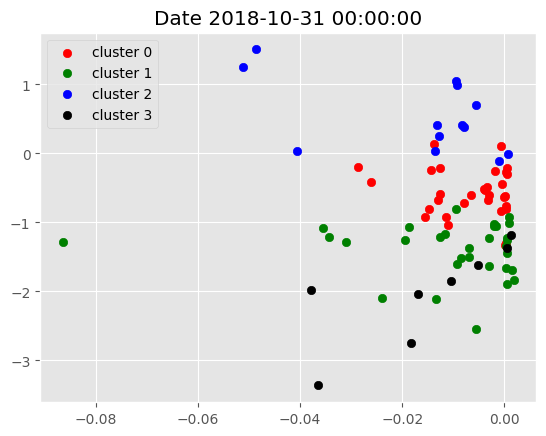

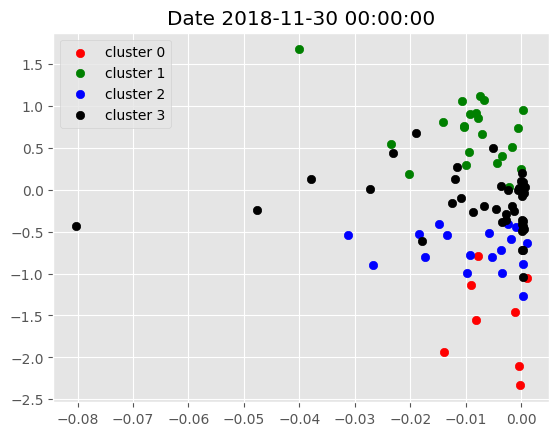

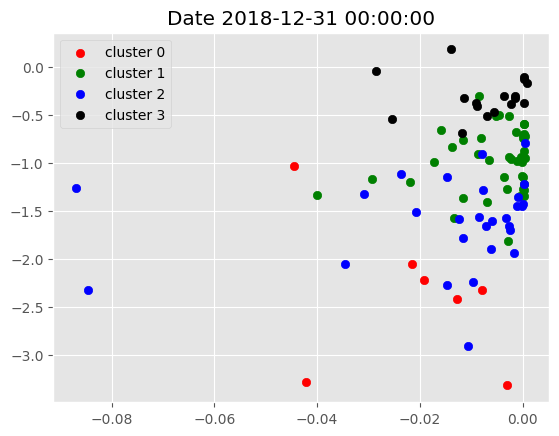

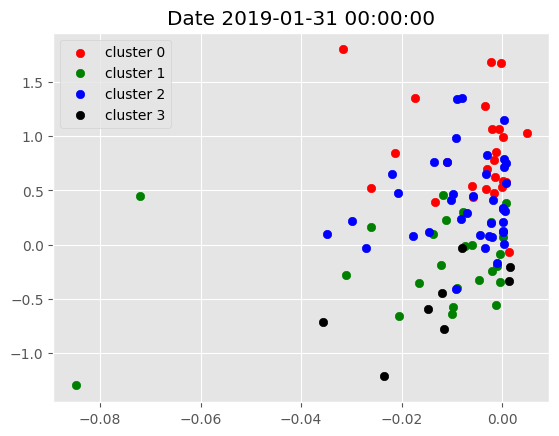

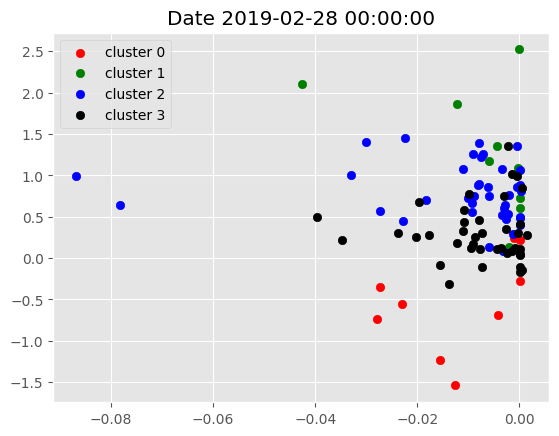

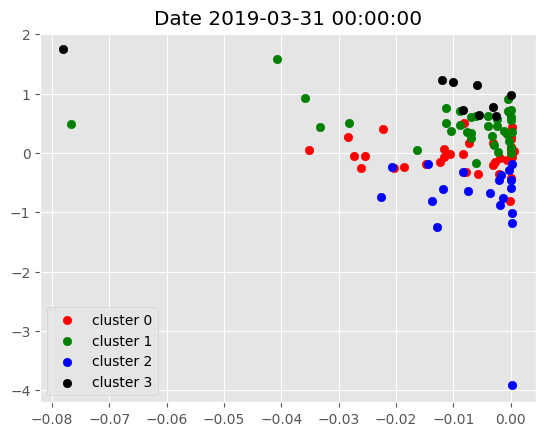

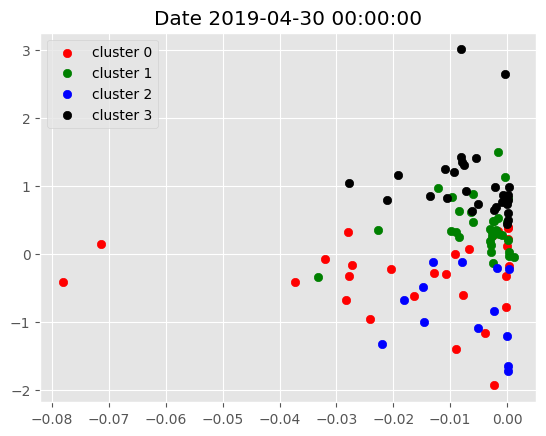

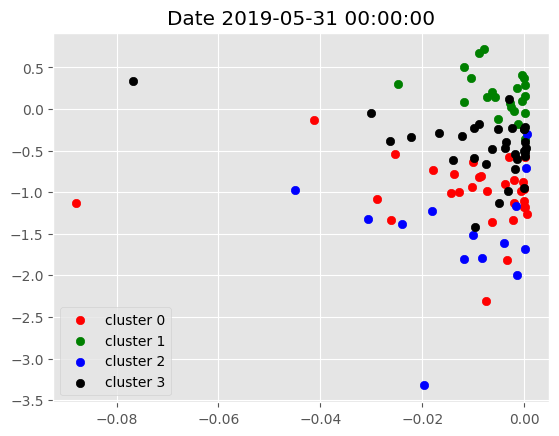

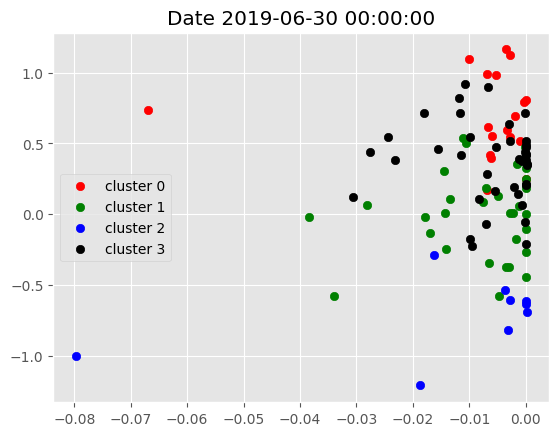

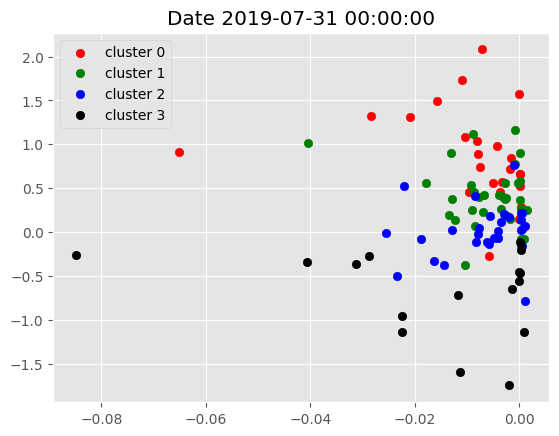

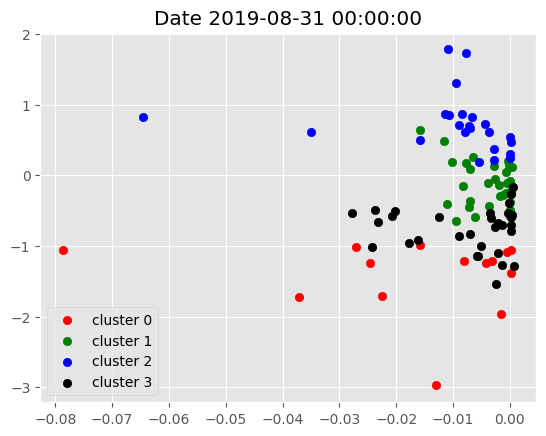

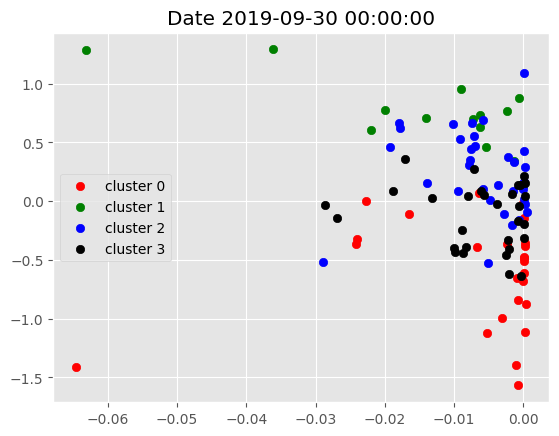

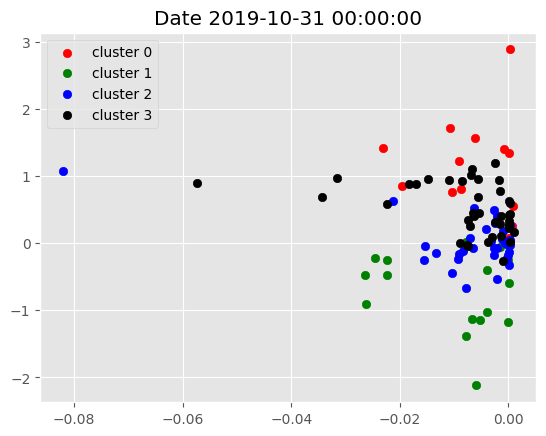

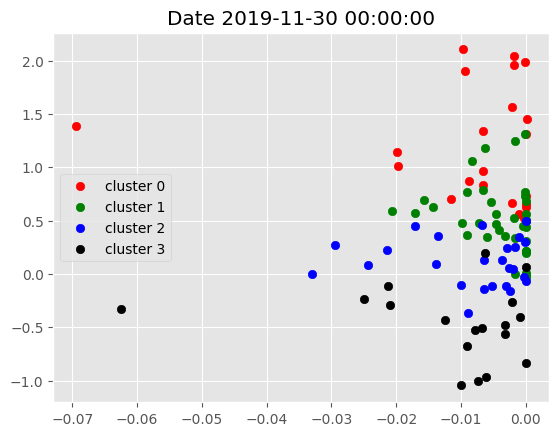

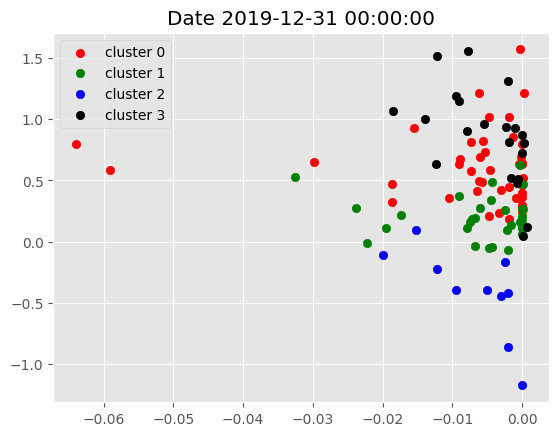

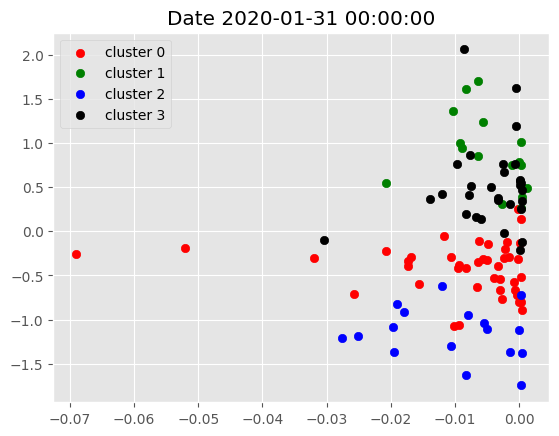

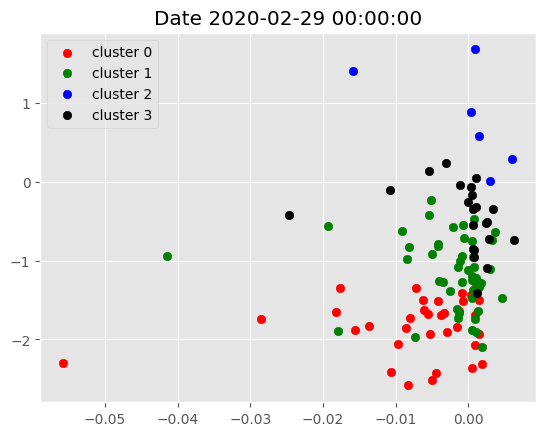

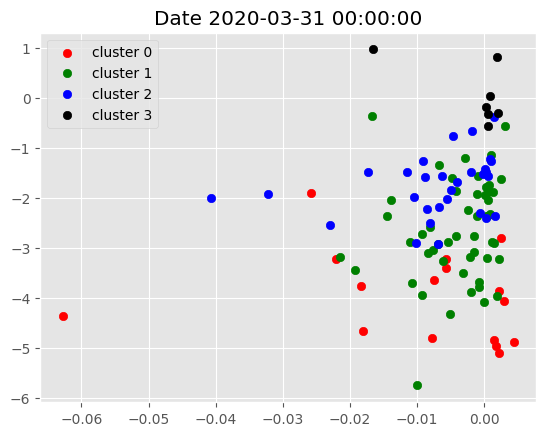

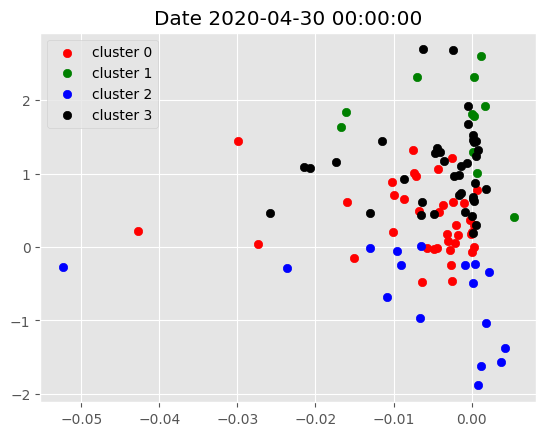

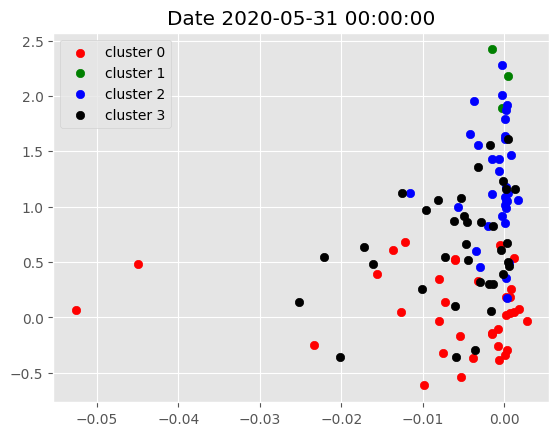

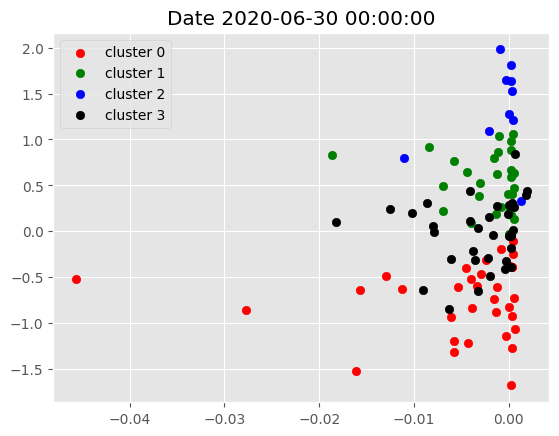

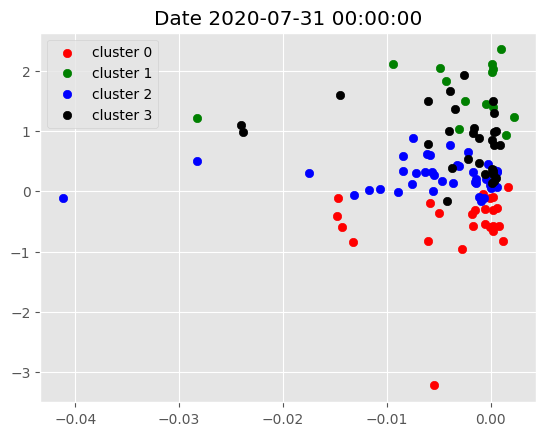

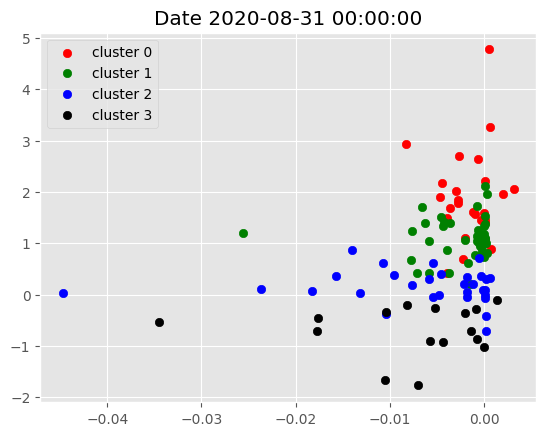

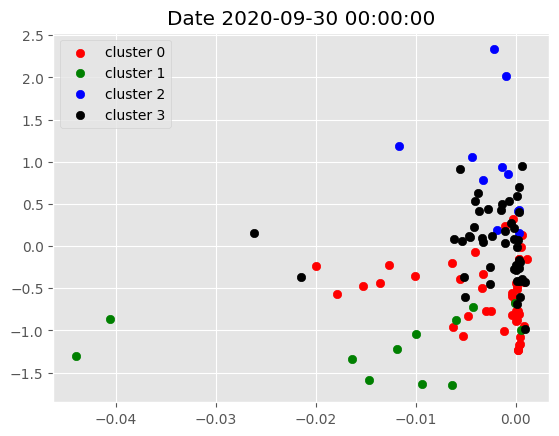

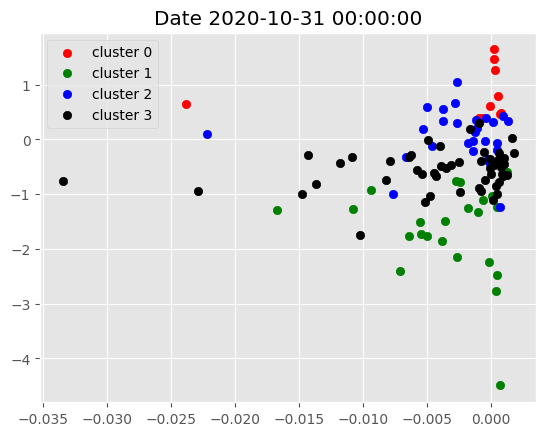

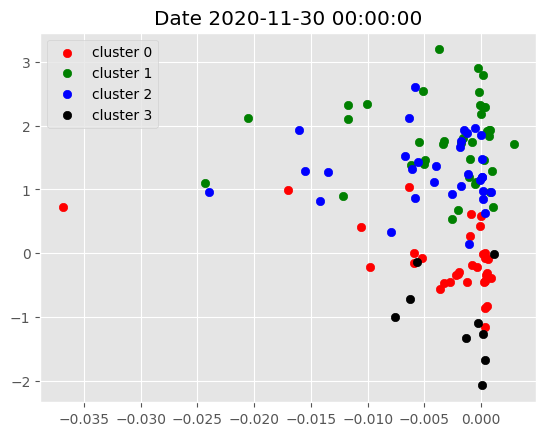

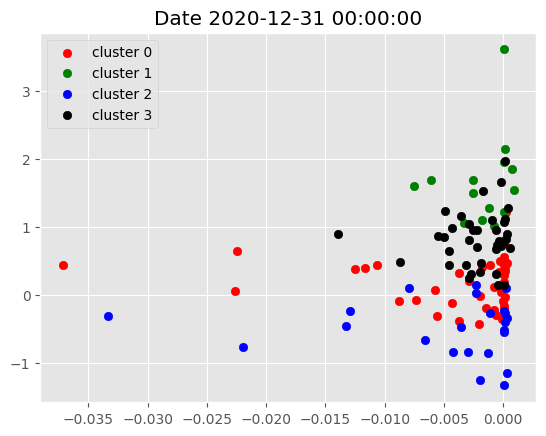

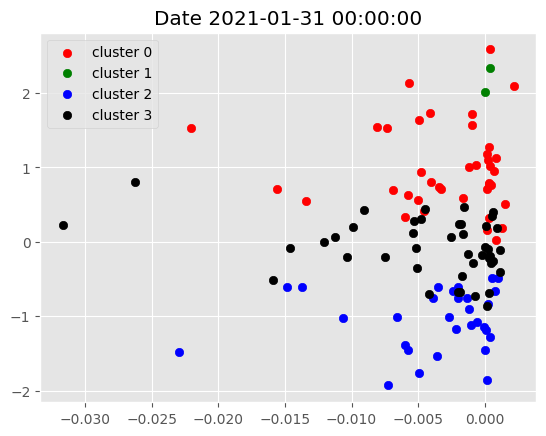

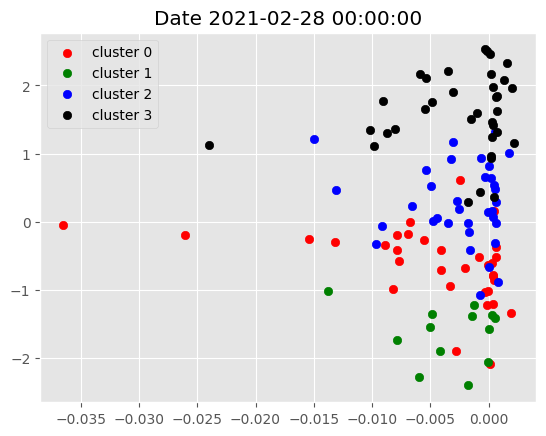

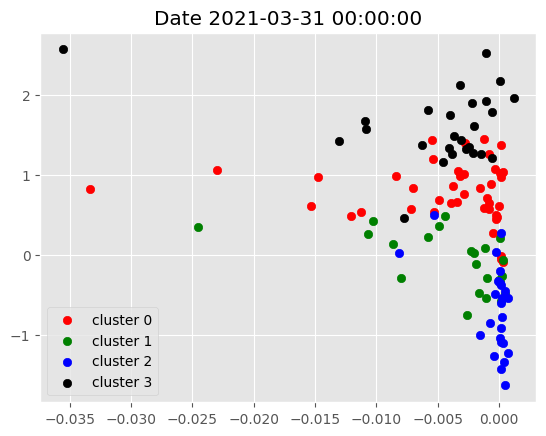

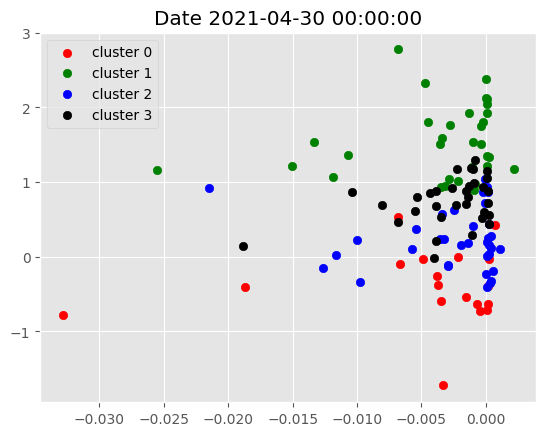

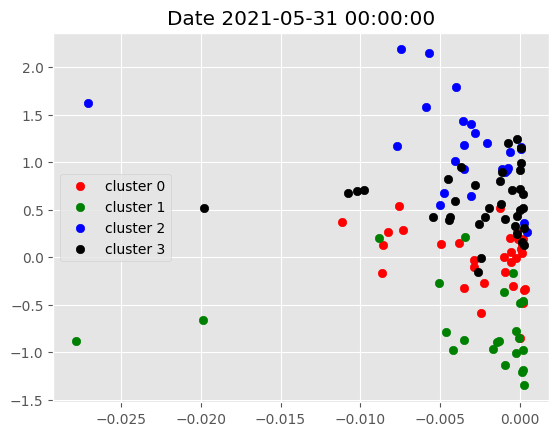

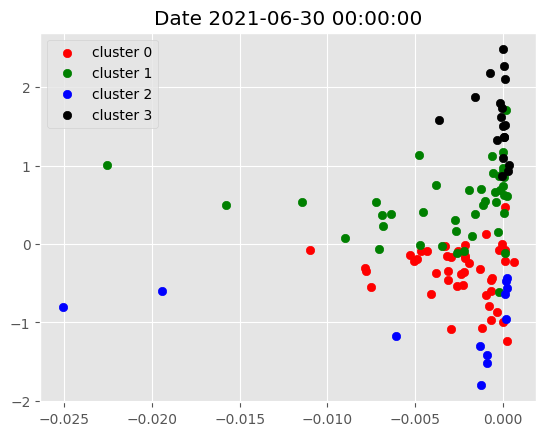

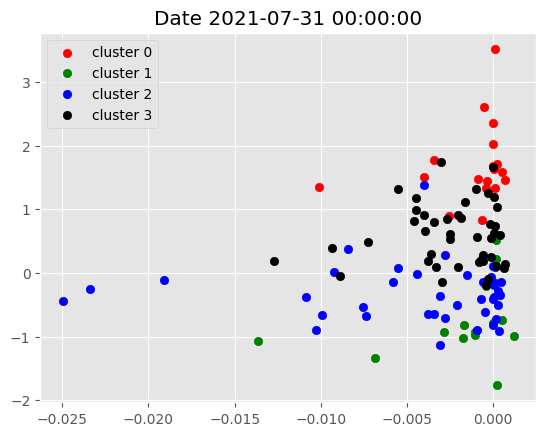

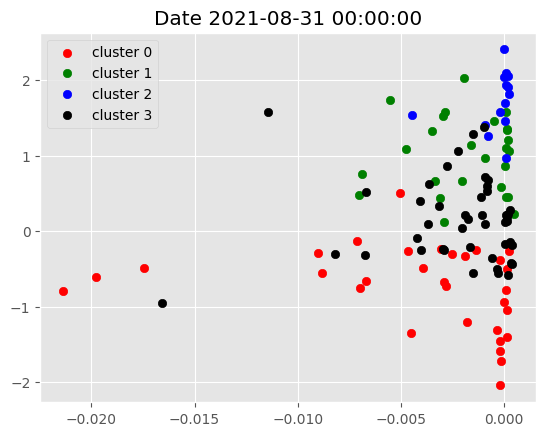

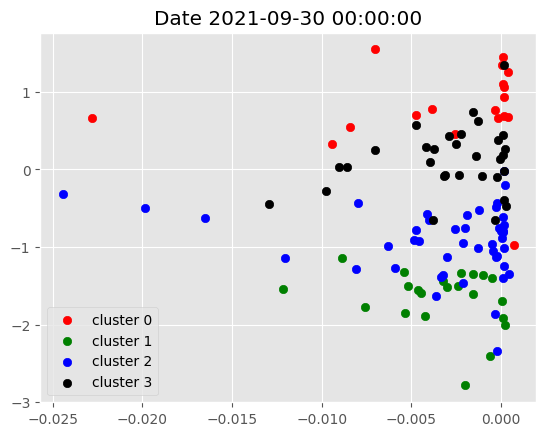

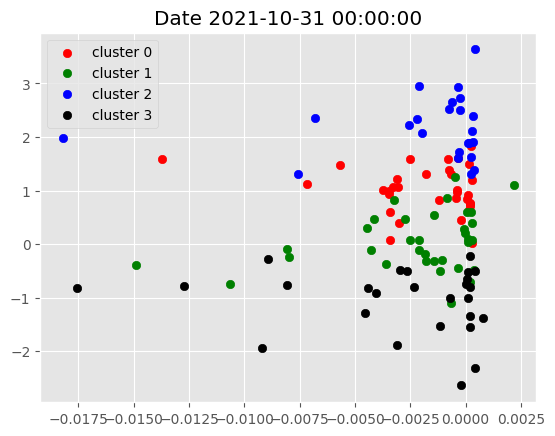

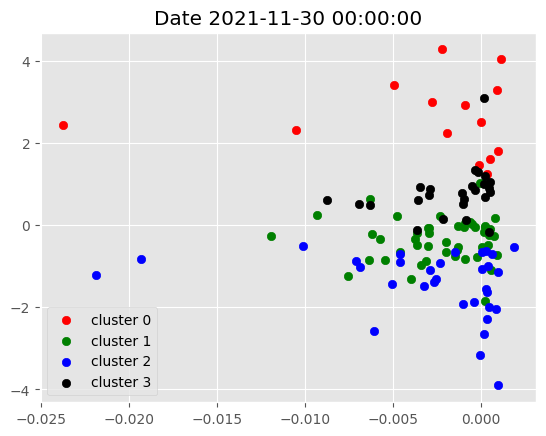

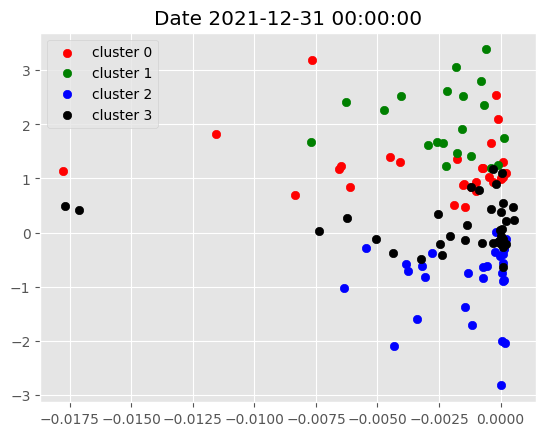

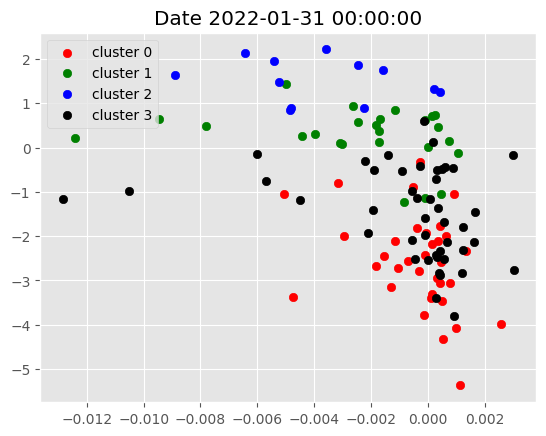

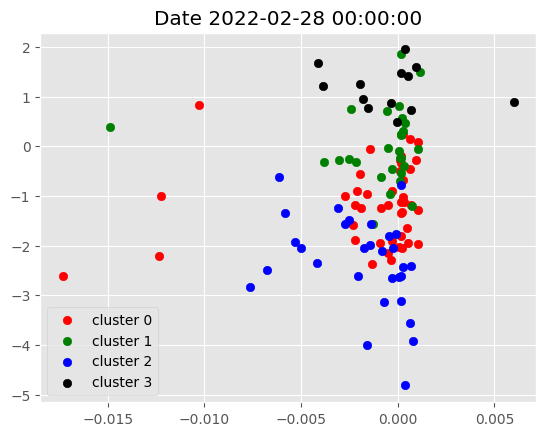

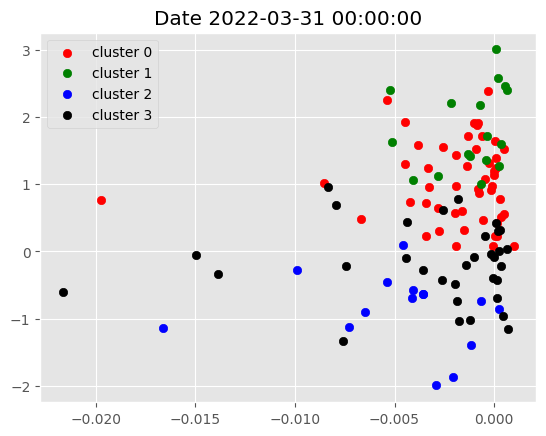

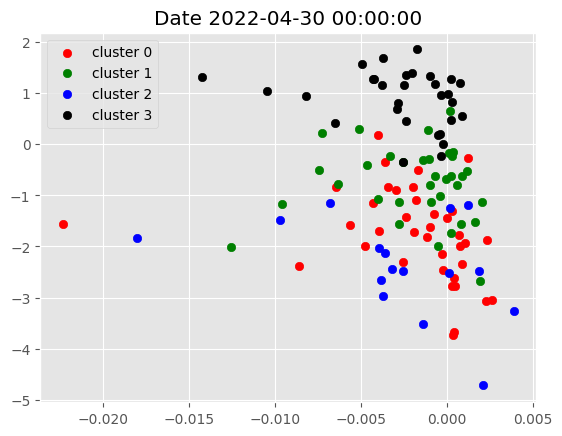

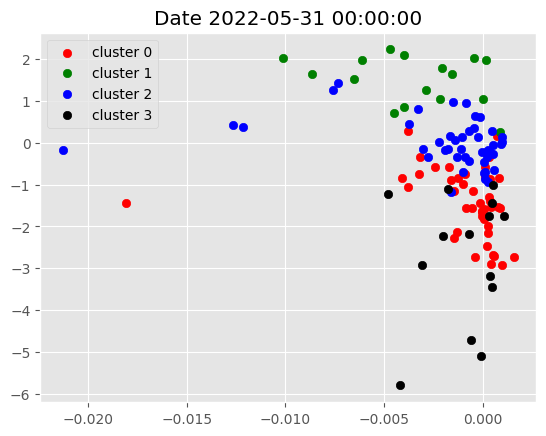

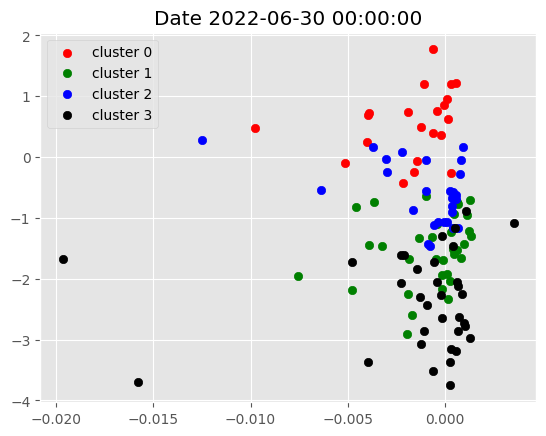

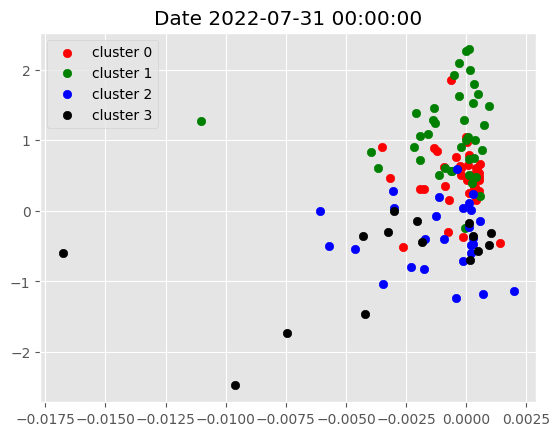

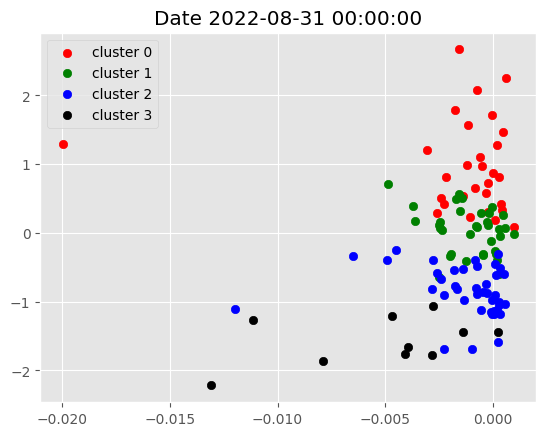

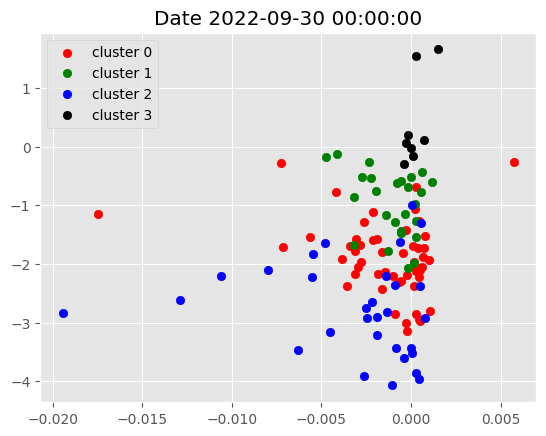

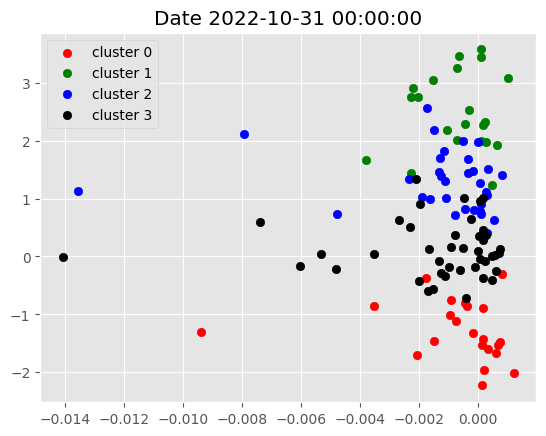

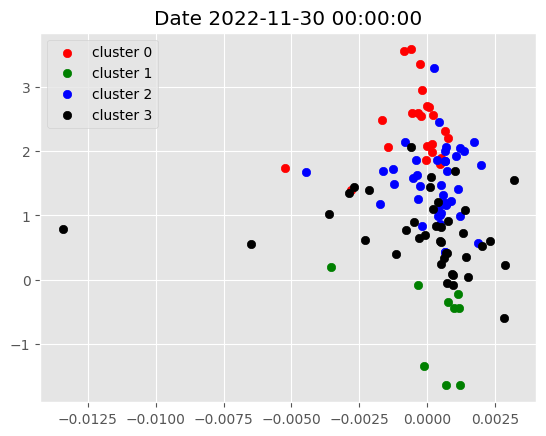

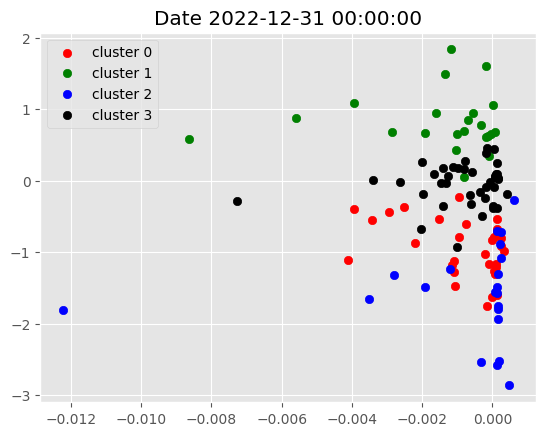

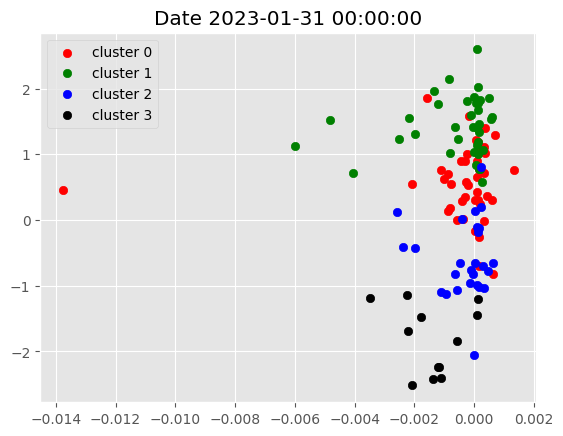

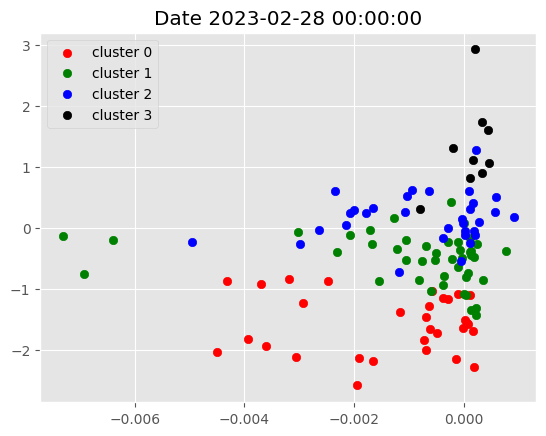

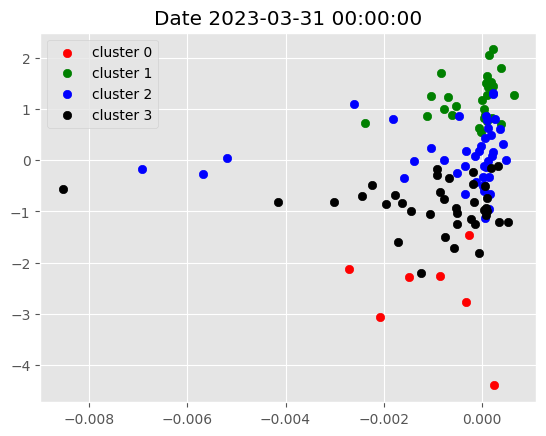

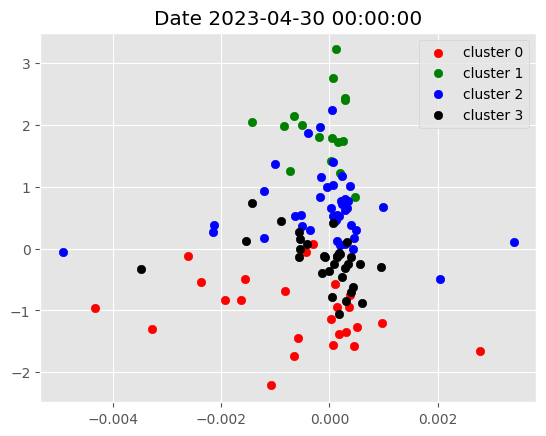

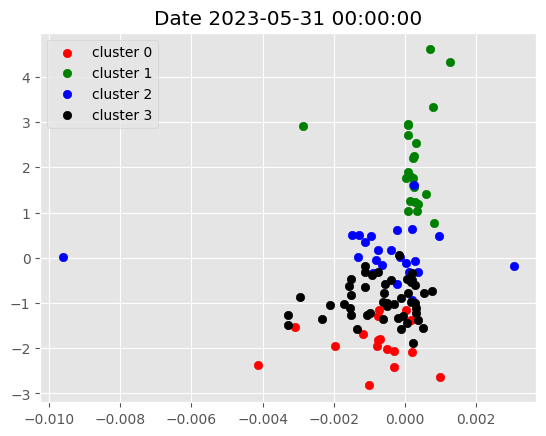

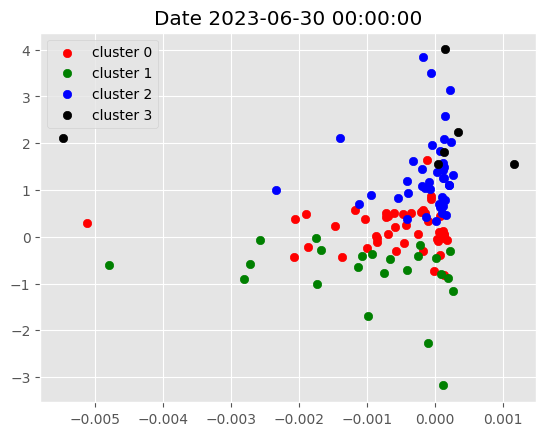

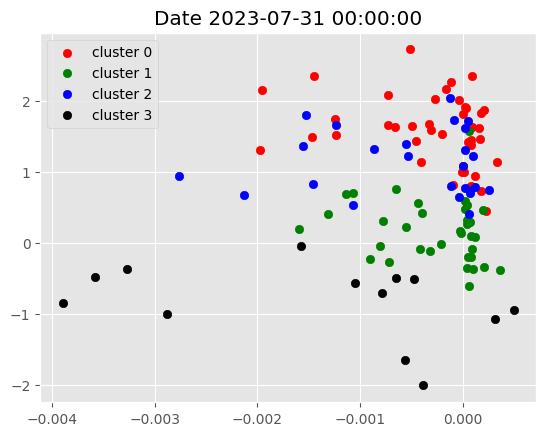

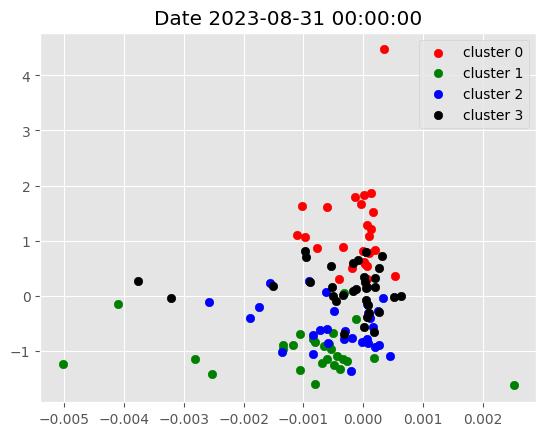

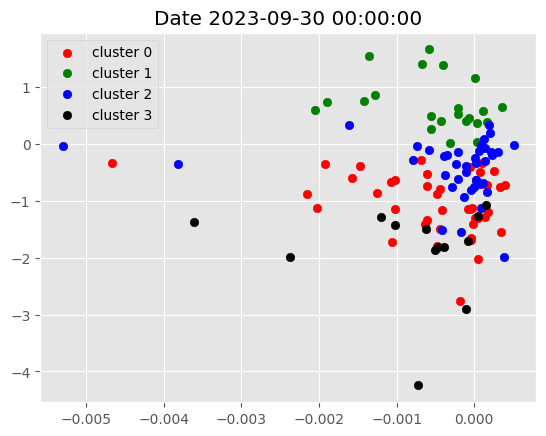

In [28]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

### Apply pre-defined centroids.

In [29]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [30]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2018-11-01': ['GE', 'HD', 'IBM', 'LOW', 'SLB', 'BMY', 'ABBV', 'REGN'],
 '2018-12-01': ['AMZN',
  'MSFT',
  'TSLA',
  'GOOGL',
  'GOOG',
  'BA',
  'V',
  'BAC',
  'JPM',
  'INTC',
  'CRM',
  'DIS',
  'CSCO',
  'BRK-B',
  'ADBE',
  'WFC',
  'MA',
  'BKNG',
  'CAT',
  'PYPL',
  'CVX',
  'T',
  'AVGO',
  'UNP',
  'TXN',
  'COST',
  'AMAT',
  'MMM',
  'NXPI',
  'CHTR',
  'GILD',
  'BIIB',
  'EBAY',
  'ACN',
  'PM',
  'USB',
  'CMG',
  'F',
  'FDX'],
 '2019-01-01': ['TSLA',
  'INTC',
  'AVGO',
  'CRM',
  'MRK',
  'PFE',
  'PG',
  'PYPL',
  'SBUX',
  'NKE',
  'CAT',
  'LLY',
  'AMGN',
  'ABT',
  'ABBV',
  'DE',
  'REGN'],
 '2019-02-01': ['NVDA', 'TSLA', 'QCOM', 'VZ', 'MCD', 'AMGN', 'CVS', 'ABBV'],
 '2019-03-01': ['AMZN',
  'AAPL',
  'META',
  'NVDA',
  'TSLA',
  'GOOGL',
  'GOOG',
  'EA',
  'MU',
  'JPM',
  'DIS',
  'WMT',
  'BMY',
  'HD',
  'PFE',
  'WFC',
  'C',
  'QCOM',
  'VZ',
  'AVGO',
  'CAT',
  'TXN',
  'AMGN',
  'GS',
  'AMAT',
  'ELV',
  'MDT',
  'NXPI',
  'MS',
  'BIIB',
  'DE',


### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [32]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 16.3 MB/s eta 0:00:00


In [33]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [43]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1], auto_adjust=False)

new_df

[*********************100%***********************]  126 of 126 completed


Price        Adj Close                                                 \
Ticker            AAPL        ABBV        ABT         ACN        ADBE   
Date                                                                    
2017-10-31   39.580864   65.727173  47.760555  128.312424  175.160004   
2017-11-01   39.077454   67.322098  47.557999  128.853226  176.250000   
2017-11-02   39.363106   66.287956  47.883869  129.276825  180.940002   
2017-11-03   40.391037   67.227417  48.852631  129.826645  182.300003   
2017-11-06   40.800804   67.700783  48.447502  129.727493  180.800003   
...                ...         ...        ...         ...         ...   
2023-09-25  174.798843  146.337540  94.540726  310.686310  511.600006   
2023-09-26  170.708847  145.637329  93.337982  304.433167  506.299988   
2023-09-27  169.189957  144.899277  92.659012  308.128235  502.600006   
2023-09-28  169.448074  144.066589  95.171188  294.788849  504.670013   
2023-09-29  169.964294  141.048019  93.939346  301.002777  509.899994   

Price                                                                   ...  \
Ticker            AMAT         AMD        AMGN         AMT        AMZN  ...   
Date                                                                    ...   
2017-10-31   51.838158   10.990000  139.713455  120.546806   55.264000  ...   
2017-11-01   51.176739   10.800000  139.872910  118.147133   55.183998  ...   
2017-11-02   51.681973   10.850000  137.472870  119.514786   54.710999  ...   
2017-11-03   51.948383   11.120000  138.294144  119.229507   55.580002  ...   
2017-11-06   51.746284   11.930000  136.189133  125.992271   56.033001  ...   
...                ...         ...         ...         ...         ...  ...   
2023-09-25  134.930313   97.379997  254.952484  157.441620  131.270004  ...   
2023-09-26  132.450806   95.959999  257.035248  154.771988  125.980003  ...   
2023-09-27  133.418884   98.070000  256.977936  151.712845  125.980003  ...   
2023-09-28  136.540497  102.760002  258.735840  154.211472  125.980003  ...   
2023-09-29  136.767700  102.820000  256.767761  156.235077  127.120003  ...   

Price         Volume                                                          \
Ticker           USB        V      VLO     VRTX        VZ     WDAY       WFC   
Date                                                                           
2017-10-31   5882000  8002500  3231000  2457100  15910000  1852600  14619200   
2017-11-01   4642600  6167300  4097800  2412600  11046600  1096400  11678300   
2017-11-02   4803800  5506600  4972900  2050000  13126900   763400  15630000   
2017-11-03   5218600  3757600  3390500  1884900   8038200  1098500  10049200   
2017-11-06   5501700  4094700  3326200  1608300  36443300  1073200  10414900   
...              ...      ...      ...      ...       ...      ...       ...   
2023-09-25   8738000  5921600  3241900   698100  17616900   894200  10624000   
2023-09-26  13742900  6193200  4936800   633600  18841600  1217300  15219400   
2023-09-27  12601100  6006700  3644000   860600  22083500  2338100  11815500   
2023-09-28   8619500  4203900  3587300   578900  18772100  9196300  12454600   
2023-09-29  10980000  6044200  4302200   896800  19759400  4066600  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-10-31  18020700  3938100   9754200  
2017-11-01  18528300  3463900   9430000  
2017-11-02  15549300  1357300   7775500  
2017-11-03  19536300  1213700   6903500  
2017-11-06  15772200  1772800   9276700  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1488 rows x 756 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [45]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
returns_dataframe

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AMAT,AMD,AMGN,AMT,AMZN,...,USB,V,VLO,VRTX,VZ,WDAY,WFC,WMT,WYNN,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01,-0.012800,0.023976,-0.004250,0.004206,0.006204,-0.012841,-0.017440,0.001141,-0.020107,-0.001449,...,0.001837,0.009862,0.022808,-0.024927,-0.000836,-0.006508,0.001246,0.007190,0.027155,0.006219
2017-11-02,0.007283,-0.015480,0.006829,0.003282,0.026262,0.009824,0.004619,-0.017308,0.011509,-0.008608,...,0.007315,-0.000810,0.010844,0.015790,-0.007766,0.002988,0.011754,0.009732,-0.009947,-0.004062
2017-11-03,0.025779,0.014073,0.020030,0.004244,0.007488,0.005142,0.024580,0.005956,-0.002390,0.015759,...,-0.004200,0.003418,-0.008740,0.034391,-0.000843,-0.007624,-0.002304,0.009861,0.000266,-0.004199
2017-11-06,0.010094,0.007017,-0.008327,-0.000764,-0.008262,-0.003898,0.070311,-0.015338,0.055170,0.008117,...,0.003653,0.005016,0.007023,-0.006623,-0.040673,-0.012284,-0.003021,-0.010988,0.008624,0.006829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,0.007353,0.012427,-0.006952,0.002843,-0.002538,0.003080,0.012191,-0.003143,-0.002953,0.016514,...,0.006271,-0.007344,0.008704,0.003256,-0.003612,0.003330,0.007972,0.004425,-0.009989,0.011161
2023-09-26,-0.023676,-0.004796,-0.012804,-0.020332,-0.010414,-0.018547,-0.014689,0.008136,-0.017102,-0.041133,...,-0.017115,-0.016026,-0.034433,0.002904,-0.005140,-0.010199,-0.022139,-0.003501,0.000331,0.001547
2023-09-27,-0.008937,-0.005081,-0.007301,0.012064,-0.007335,0.007282,0.021750,-0.000223,-0.019963,0.000000,...,-0.015258,-0.000653,0.016601,-0.005817,-0.018046,0.006825,0.005153,-0.004812,0.016732,0.032038


Max Sharpe Optimization failed for 2018-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-07-01, Continuing with Equal-Weights
No return data found for period 2023-10-01 to 2023-10-31, skipping...
'retur

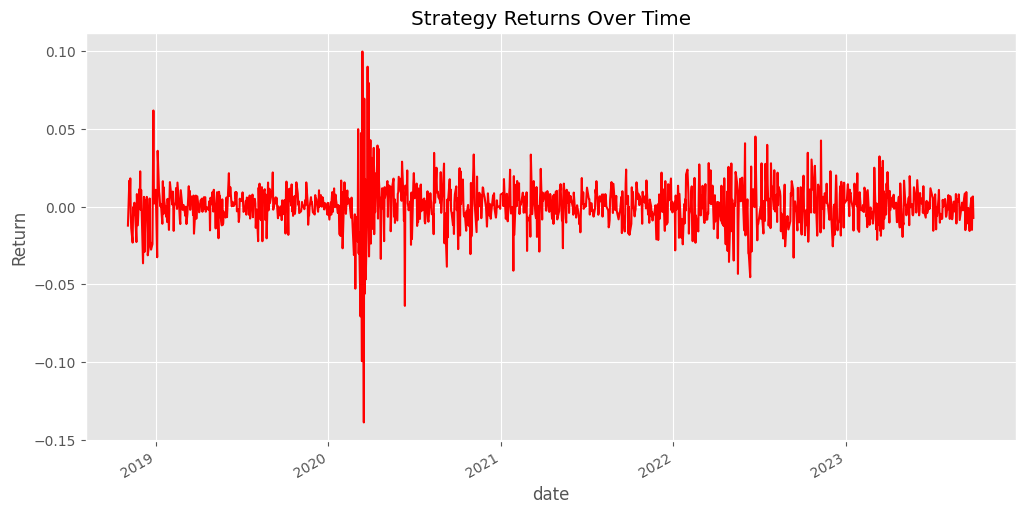

,date,Strategy Return
0,2018-11-02,-0.012169
1,2018-11-05,0.016743
2,2018-11-06,0.006748
3,2018-11-07,0.018193
4,2018-11-08,-0.003535
...,...,...
1171,2023-09-25,0.005765
1172,2023-09-26,-0.014922
1173,2023-09-27,0.005854
1174,2023-09-28,0.006592


In [62]:
# new
# Initialize empty portfolio DataFrame
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]

        # Get data for optimization
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        # Try to optimize weights
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                     lower_bound=round(1/(len(optimization_df.columns)*2),3))
            weights = pd.Series(weights).to_frame(0)
            success = True
        except Exception as e:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        # Use equal weights if optimization fails
        if not success:
            equal_weight = 1/len(cols)
            weights = pd.Series({ticker: equal_weight for ticker in cols}).to_frame(0)

        # Calculate returns for this period
        adj_close_data = new_df[start_date:end_date]['Adj Close'][cols]
        period_returns = adj_close_data.pct_change().dropna()

        # If no return data for this period, skip
        if period_returns.empty:
            print(f"No return data found for period {start_date} to {end_date}, skipping...")
            continue

        # Calculate weighted returns for the portfolio
        weighted_returns = period_returns.dot(weights[0])

        # Add to the portfolio DataFrame
        temp_df = pd.DataFrame(weighted_returns, columns=['Strategy Return'])
        portfolio_df = pd.concat([portfolio_df, temp_df])

    except Exception as e:
        print(e)

# Remove duplicate rows if any exist
portfolio_df = portfolio_df.drop_duplicates()

# This keeps the dates as the index
print("'return'")

# To create a proper plot, keep the dates as index (don't reset_index)
portfolio_df.index.name = 'date'  # Name the index 'date'

# Make a plot with proper date axis
plt.figure(figsize=(12, 6))
portfolio_df['Strategy Return'].plot(color='red')
plt.title('Strategy Returns Over Time')
plt.ylabel('Return')
plt.grid(True)
plt.show()

# Create a display version with reset_index
display_df = portfolio_df.reset_index()
# Display without showing row numbers
display(display_df)

## 8. Visualize Portfolio returns and compare to SP500 returns.

In [67]:
# Download SPY data with auto_adjust=False
spy = yf.download(tickers='SPY',
                 start='2015-01-01',
                 end=dt.date.today(),
                 auto_adjust=False)

# Calculate SPY returns
spy_returns = np.log(spy['Adj Close']).diff().dropna()
spy_returns.name = 'SPY Buy&Hold'

# Ensure portfolio_df has a DatetimeIndex
if not isinstance(portfolio_df.index, pd.DatetimeIndex):
    portfolio_df.index = pd.to_datetime(portfolio_df.index)

# Add the SPY returns as a new column directly
portfolio_df = portfolio_df.copy()  # Make a copy to avoid modifying the original
portfolio_df['SPY Buy&Hold'] = spy_returns.reindex(index=portfolio_df.index)

# Display the result
portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
date,,
2018-11-02,-0.012169,-0.005940
2018-11-05,0.016743,0.005502
2018-11-06,0.006748,0.006308
2018-11-07,0.018193,0.021183
2018-11-08,-0.003535,-0.001817
...,...,...
2023-09-25,0.005765,0.004196
2023-09-26,-0.014922,-0.014800
2023-09-27,0.005854,0.000399


In [69]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return

,Strategy Return,SPY Buy&Hold
date,,
2018-11-02,-0.012169,-0.005940
2018-11-05,0.004370,-0.000471
2018-11-06,0.011148,0.005834
2018-11-07,0.029543,0.027140
2018-11-08,0.025904,0.025274
...,...,...
2023-09-25,0.593093,0.341679
2023-09-26,0.569321,0.321821
2023-09-27,0.578508,0.322349


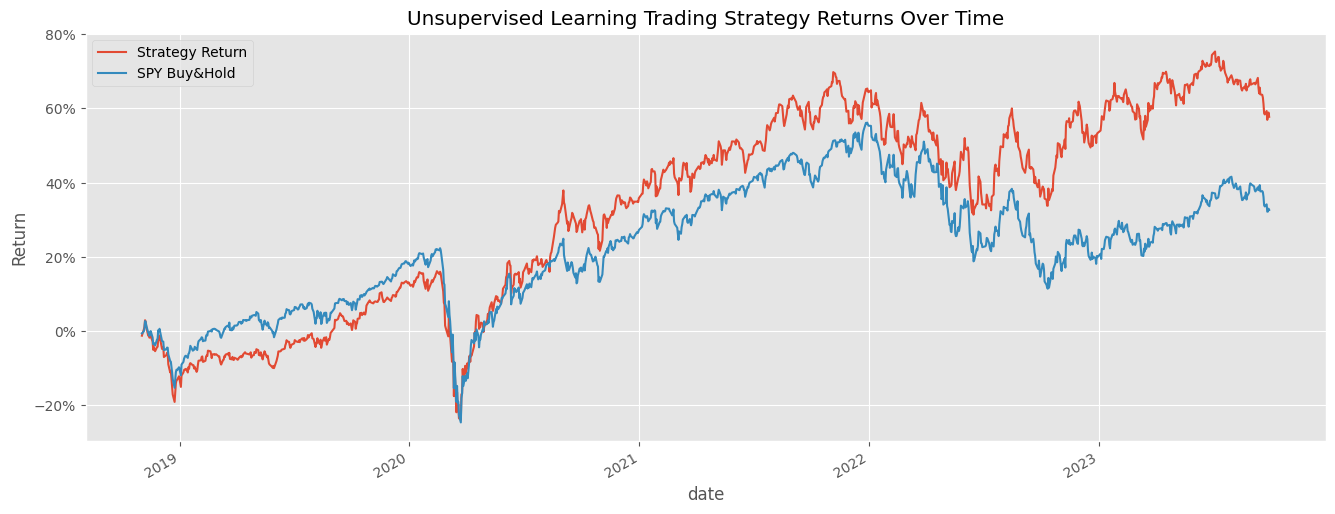

In [76]:
portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()